In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from scipy.ndimage import gaussian_filter
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Using TensorFlow backend.


In [3]:
sess = K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=False,
                                                       gpu_options=K.tf.GPUOptions(allow_growth=True),
                                                       log_device_placement=False))
K.set_session(sess)

In [4]:
log_pca_files = sorted(glob("/glade/work/dgagne/spatial_storm_results_20171220/hail_logistic_pca_sample_*.pkl"))
log_mean_files = sorted(glob("/glade/work/dgagne/spatial_storm_results_20171220/hail_logistic_mean_sample_*.pkl"))

In [3]:
label_spots_t = [(2, 2),
               (10, 10), (10, 26), 
               (20, 10), (20, 26)]
label_spots_d = [
               (5, 10), (5, 22), 
               (18, 12), (18, 28),
               (28, 28)]

In [8]:
samples = np.arange(0, 30)
for sample in samples:
    print(sample)
    with open(log_pca_files[sample], "rb") as pca_file:
        log_pca_obj = pickle.load(pca_file)
    k_log_input = Input((75,))
    k_log_out = Dense(1, activation="sigmoid")(k_log_input)
    k_mod = Model(k_log_input, k_log_out)
    k_mod.compile("sgd", loss="mse")
    k_mod.layers[1].set_weights([log_pca_obj.model.coef_.T, log_pca_obj.model.intercept_])
    loss = K.mean((k_mod.output - 1) ** 2)
    grad = K.gradients(loss, [k_mod.input])[0]
    grad /= K.maximum(K.std(grad), K.epsilon())
    grad_func = K.function([k_mod.input], [grad, loss])
    input_vals = np.zeros((1, 75))
    for i in range(10):
        g_val, l_val = grad_func([input_vals])
        print(l_val)
        input_vals -= 0.1 * g_val
    layer_vis = np.zeros((1, 32, 32, 15))
    for v in range(15):
        layer_vis[0, :, :, v] = log_pca_obj.pca[v].inverse_transform(input_vals[:, v * 5:(v+1)*5]).reshape(32, 32)
    fig = plt.figure(figsize=(12, 4))
    heights = [500, 700, 850]
    for a in np.arange(3):
        plt.subplot(1,3, a + 1)
        hght_g = gaussian_filter(layer_vis[0, :, :, a], 1)
        hght_g /= hght_g.std()
        hght = plt.contourf(np.arange(0, 32) + 0.5, np.arange(0, 32) + 0.5, hght_g, [-3, -2, -1, 1, 2, 3], extend="both", cmap="RdBu_r", zorder=0)
        tmpc_g = gaussian_filter(layer_vis[0, :, :, 3 + a], 1)
        tmpc_g /= tmpc_g.std()
        tmpc = plt.contour(np.arange(0, 32) + 0.5, np.arange(0, 32) + 0.5, tmpc_g, 
                           [-3, -2, -1, 1, 2, 3], linewidths=3, colors=["orangered"], zorder=0.1)
        if np.abs(tmpc_g).max() > 1: 
            plt.clabel(tmpc, fmt="%1.0f", fontsize=12, manual=label_spots_t)
        dewp_g = gaussian_filter(layer_vis[0, :, :, 6 + a], 1)
        dewp_g /= dewp_g.std()
        dewp = plt.contour(np.arange(0, 32) + 0.5, np.arange(0, 32) + 0.5,
                           dewp_g, [-3, -2, -1,1,2,3], linewidths=2, colors=["purple"], zorder=0.1)
        if np.abs(dewp_g).max() > 1:
            plt.clabel(dewp, fmt="%1.0f", fontsize=12, manual=label_spots_d)
        u_g = gaussian_filter(layer_vis[0, :, :, 9 + a], 1)
        u_g /= u_g.std()
        v_g = gaussian_filter(layer_vis[0, :, :, 12 + a], 1)
        v_g /= v_g.std()
        wind_mask = np.sqrt(u_g ** 2 + v_g ** 2) < 0.5
        u_g[wind_mask] = 0
        v_g[wind_mask] = 0
        qv = plt.quiver(np.arange(0, 32, 2) + 0.5, np.arange(0, 32, 2) + 0.5, u_g[::2, ::2],
                        v_g[::2, ::2], color="k", scale=64)
        plt.xticks(np.arange(0, 36, 8), np.arange(0, 36, 8) * 3)
        plt.yticks(np.arange(0, 36, 8), np.arange(0, 36, 8) * 3)
        plt.xlabel("West-East Distance (km)", fontsize=12)
        plt.ylabel("South-North Distance (km)", fontsize=12)
        plt.title("{0:d} hPa".format(heights[a]), fontsize=14)
        rect = patches.Rectangle((18, 0), 14, 6, facecolor='white', edgecolor='k', alpha=0.9, zorder=1)
        plt.gca().add_patch(rect)
        plt.text(19, 5, "Temperature", color='orangered', fontsize=10, fontweight="bold", ha="left", va="center", zorder=3)
        plt.text(19, 3, "Dewpoint", color="purple", fontsize=10, fontweight="bold", ha="left", va="center", zorder=3)
        plt.quiverkey(qv, 20, 1, 3, 'Wind (3 $\sigma$)', coordinates='data', labelpos='E')
        
    cax = fig.add_axes([0.91, 0.1, 0.02, 0.8])
    fig.colorbar(hght, cax=cax, label="Geopotential Height Anomaly")
    plt.suptitle("Logistic PCA Optimized Hailstorm Model {0:02d}".format(sample), fontsize=16, y=0.99)
    plt.savefig("./logistic_pca_best_hailstorm_{0:02d}.pdf".format(sample), bbox_inches="tight", dpi=300)
    plt.close()

0


/glade/u/apps/dav/opt/python/3.6.4/intel/17.0.1/pkg-library/20180801-DL/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator PCA from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/glade/u/apps/dav/opt/python/3.6.4/intel/17.0.1/pkg-library/20180801-DL/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.811726
0.60253894
0.32432315
0.112430505
0.026028171
0.004670861
0.0007405331
0.00011140738
1.6414706e-05
2.3990485e-06
1
0.7956542
0.5912344
0.32806012
0.12299678
0.031943563
0.006498314
0.0011642411
0.00019693233
3.2509623e-05
5.3134413e-06
2
0.82901067
0.61857045
0.3266377
0.10606852
0.022157073
0.0035466412
0.0005024635
6.780406e-05
8.98404e-06
1.1824978e-06
3
0.8155643
0.58706695
0.28669482
0.08319363
0.015567772
0.0022793734
0.00030022734
3.7983315e-05
4.7356966e-06
5.873636e-07
4
0.8090329
0.6121765
0.34935158
0.13502984
0.035834126
0.007361639
0.001321436
0.00022307785
3.669115e-05
5.970946e-06
5
0.820409
0.62160677
0.34921822
0.12888743
0.03182698
0.0060289223
0.0009988914
0.00015612009
2.3829052e-05
3.6028214e-06
6
0.8196742
0.60181904
0.3089128
0.09705811
0.019779917
0.003122682
0.00043921304
5.901626e-05
7.795601e-06
1.0232342e-06
7
0.7977882
0.5701551
0.2830053
0.0872099
0.017909626
0.002904439
0.00042308975
5.9032744e-05
8.102445e-06
1.1053711e-06
8
0.7877181
0.5714335


In [7]:
samples = np.arange(0, 30)
log_mean_grad_vals = np.zeros((30, 15))
for sample in samples:
    print(sample)
    with open(log_mean_files[sample], "rb") as pca_file:
        log_mean_obj = pickle.load(pca_file)
    k_log_input = Input((15,))
    k_log_out = Dense(1, activation="sigmoid")(k_log_input)
    k_mod = Model(k_log_input, k_log_out)
    k_mod.compile("sgd", loss="mse")
    k_mod.layers[1].set_weights([log_mean_obj.coef_.T, log_mean_obj.intercept_])
    loss = K.mean((k_mod.output - 1) ** 2)
    grad = K.gradients(loss, [k_mod.input])[0]
    grad /= K.maximum(K.std(grad), K.epsilon())
    grad_func = K.function([k_mod.input], [grad, loss])
    input_vals = np.zeros((1, 15))
    for i in range(10):
        g_val, l_val = grad_func([input_vals])
        print(l_val)
        input_vals -= 0.1 * g_val
    log_mean_grad_vals[sample] = input_vals

0
0.7484292
0.0016412579
7.724868e-08
3.1974423e-12
3.1974423e-12
3.1974423e-12
3.1974423e-12
3.1974423e-12
3.1974423e-12
3.1974423e-12
1


/glade/u/apps/dav/opt/python/3.6.4/intel/17.0.1/pkg-library/20180801-DL/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.7401594
0.003201533
3.4064578e-07
3.274181e-11
3.1391778e-11
3.1391778e-11
3.0070165e-11
3.0070165e-11
3.0070165e-11
2.8776979e-11
2
0.7459781
0.001266427
4.6171156e-08
1.4210854e-12
1.4210854e-12
1.4210854e-12
1.4210854e-12
1.4210854e-12
1.4210854e-12
1.4210854e-12
3
0.74567807
0.0014877497
6.468528e-08
2.7853275e-12
2.7853275e-12
2.7853275e-12
2.4016347e-12
2.4016347e-12
2.4016347e-12
2.4016347e-12
4
0.7408322
0.0012734918
4.9084605e-08
1.7195133e-12
1.7195133e-12
1.7195133e-12
1.7195133e-12
1.7195133e-12
1.7195133e-12
1.7195133e-12
5
0.74566704
0.0016055999
7.5797715e-08
3.1974423e-12
3.1974423e-12
3.1974423e-12
3.1974423e-12
3.1974423e-12
3.1974423e-12
3.1974423e-12
6
0.75352514
0.0012622941
4.2507082e-08
1.4210854e-12
1.4210854e-12
1.4210854e-12
1.4210854e-12
1.4210854e-12
1.4210854e-12
1.4210854e-12
7
0.7380528
0.001810013
1.047514e-07
5.684342e-12
5.684342e-12
5.684342e-12
5.684342e-12
5.684342e-12
5.684342e-12
5.684342e-12
8
0.75918484
0.0018819141
9.2188785e-08
4.106937e-12


In [18]:
input_vars = ["Height", "Temperature", "Dewpoint", "U-Wind", "V-Wind"]
levels = ["500 hPa", "700 hPa", "850 hPa"]
all_input_vars = []
for iv in input_vars:
    for lev in levels:
        all_input_vars.append(iv + " " + lev)

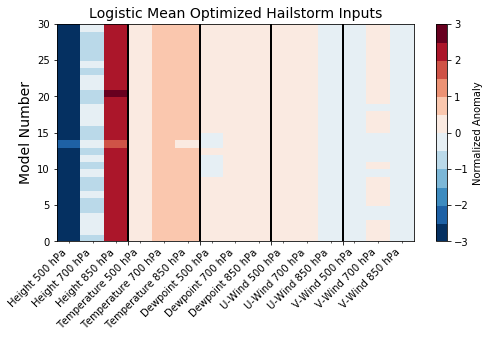

In [79]:
plt.figure(figsize=(8, 4))
gvcomp = plt.pcolormesh(log_mean_grad_vals / log_mean_grad_vals.std(), vmin=-3, vmax=3, cmap=plt.get_cmap("RdBu_r", 12))
#plt.quiver(np.ones(30) * 9.5, np.arange(30), log_mean_grad_vals[:, 9], log_mean_grad_vals[:, 12], scale=1.5, headwidth=1, headlength=1)
#plt.quiver(np.ones(30) * 10.5, np.arange(30), log_mean_grad_vals[:, 10], log_mean_grad_vals[:, 13], scale=1.5, headwidth=1, headlength=1)
#plt.quiver(np.ones(30) * 11.5, np.arange(30), log_mean_grad_vals[:, 11], log_mean_grad_vals[:, 14], scale=1.5)
plt.ylabel("Model Number", fontsize=14)
plt.gca().set_xticks(np.arange(0.5, 15), minor=True)
plt.gca().set_xticks(np.arange(3, 15, 3), minor=False)
plt.gca().set_xticklabels([], minor=False)
plt.gca().set_xticklabels(all_input_vars, rotation=45, ha="right", minor=True) 
plt.colorbar(gvcomp, label="Normalized Anomaly")
plt.grid(axis='x', color='k', lw=2)
plt.title("Logistic Mean Optimized Hailstorm Inputs", fontsize=14)
plt.savefig("logistic_mean_optimized_hail.pdf", dpi=300, bbox_inches="tight")

(array([ 29.,   1.,   0.,   6.,  41., 248.,  95.,   0.,   1.,  29.]),
 array([-0.88712046, -0.72206973, -0.557019  , -0.39196828, -0.22691755,
        -0.06186682,  0.10318391,  0.26823464,  0.43328536,  0.59833609,
         0.76338682]),
 <a list of 10 Patch objects>)

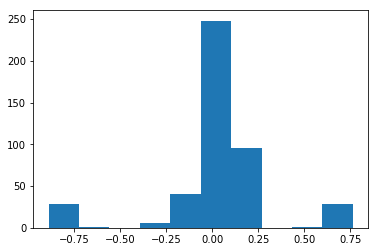

In [10]:
plt.hist(log_mean_grad_vals.ravel())